### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net1Loops.inp`. Let's start by setting up the model:

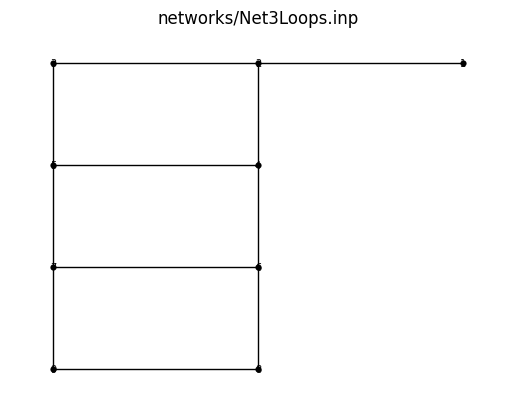

<Axes: title={'center': 'networks/Net3Loops.inp'}>

In [33]:
import os
import wntr
import wntr_quantum

os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"

# set up network model
inp_file = 'networks/Net1Loops.inp'
inp_file = 'networks/Net3Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# print options
# dict(wn.options.hydraulic)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [34]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

util_path = os.path.join(epanet_path, 'src/py/')
sys.path.append(util_path)

from quantum_linsolve import load_json_data
epanet_A, epanet_b = load_json_data(os.path.join(epanet_tmp,'smat.json'))

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Your EPANET quantum path: /home/nico/QuantumApplicationLab/vitens/EPANET
Your EPANET temp dir: /home/nico/.epanet_quantum

Size of the Jacobian in EPANET simulator: 8
Size of the b vector in EPANET simulator: 8


(name          2          3          4          5          6          7  \
 0     52.194599  29.139265  42.472969  26.306131  27.643869  23.355785   
 
 name          8         9             1  
 0     13.969273  7.612091  4.394531e-07  ,
 name         1         2         3        4        5         6         7  \
 0     0.336412  0.052491  0.256151  0.03239  0.19043  0.078751  0.024721   
 
 name         8         9        10        11  
 0    -0.017889  0.020009  0.005311  0.007349  )

### Solve linear system with VQLS and the final matrices from EPANET

For testing purposes, we start by solving the linear system with VQLS and the final A and b matrices from the classical EPANET simulator. Here, we are **preconditioning** the initial linear system using diagonal scaling and also using a **mix of two classical optimizers**.

In [39]:
import numpy as np

from qiskit.primitives import Estimator

from quantum_newton_raphson.hhl_solver import HHL_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

estimator = Estimator()

linear_solver = HHL_SOLVER(
    estimator=estimator,
)


res = linear_solver(epanet_A, epanet_b)

Let's check the evolution of the cost function

and visualize graphically the solution

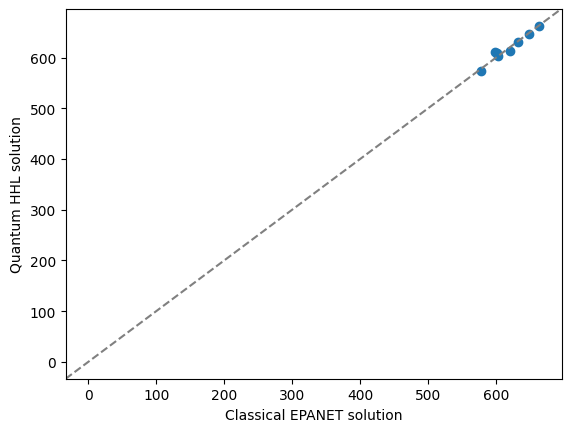

(array([599.121, 603.574, 632.034, 601.561, 578.432, 620.536, 663.368, 647.877]),
 array([610.144, 603.148, 629.941, 608.536, 573.377, 612.059, 662.437, 646.793]))

In [40]:
import numpy as np 
import matplotlib.pyplot as plt
ref = np.linalg.solve(epanet_A.todense(), epanet_b)

plt.scatter(ref, res.solution)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.xlabel("Classical EPANET solution")
plt.ylabel("Quantum HHL solution")
plt.show()

ref, res.solution

In [37]:
import numpy as np
A = epanet_A.todense()
b = epanet_b 
A.shape
# Apad = np.eye(8,8)
# Apad[:6,:6] = A
# bpad = np.zeros(8)
# bpad[:6] = b
circuits = linear_solver._solver.construct_circuit(A,b)

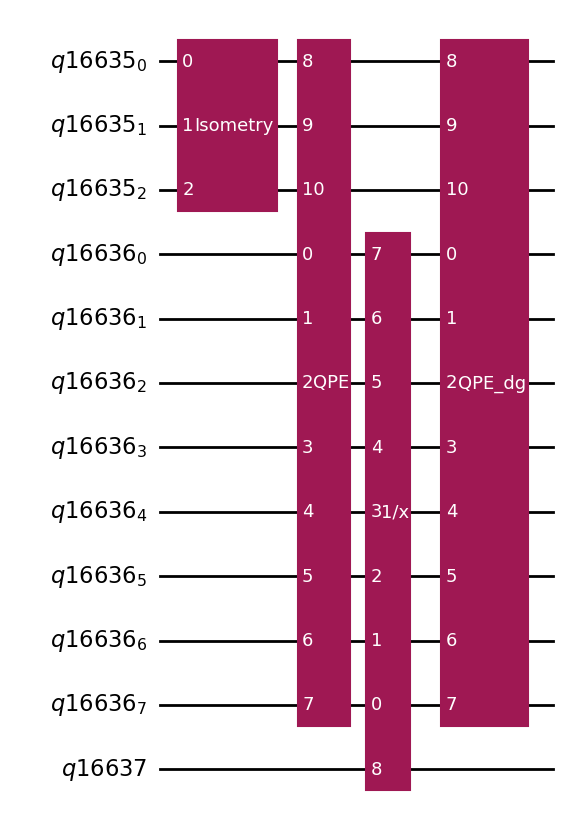

In [38]:
circuits.decompose().draw('mpl')